In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('/content/loan_sample.csv')


In [7]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,22000,22000,22000.0,36 months,9.17,701.34,B,B2,Registered Nurse,5 years,RENT,73000.0,Source Verified,Jun-2015,0,n,NaN,NaN,debt_consolidation,Debt consolidation,913xx,CA,13.16,0.0,Sep-1999,2.0,29.0,NaN,7.0,0.0,33797,59.4,22.0,f,0.0,0.0,25251.046476,25251.05,...,0.0,0.0,56900.0,33797.0,47600.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,8000,8000,8000.0,36 months,5.32,240.92,A,A1,Foreman,10+ years,MORTGAGE,89000.0,Not Verified,Aug-2016,0,n,NaN,NaN,debt_consolidation,Debt consolidation,740xx,OK,6.63,0.0,Dec-2001,0.0,NaN,118.0,8.0,1.0,5405,34.6,16.0,f,0.0,0.0,8602.708787,8602.71,...,1.0,0.0,236146.0,17380.0,10500.0,18039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,6000,6000,6000.0,36 months,9.75,192.90,B,B3,Staff Accountant,1 year,RENT,65000.0,Not Verified,Mar-2016,0,n,NaN,NaN,debt_consolidation,Debt consolidation,980xx,WA,24.26,0.0,Oct-2004,0.0,NaN,NaN,17.0,0.0,27715,48.5,27.0,w,0.0,0.0,6518.164684,6518.16,...,0.0,0.0,89841.0,41070.0,16000.0,32641.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,5300,5300,5300.0,36 months,12.39,177.03,C,C1,ADMINISTRATOR,10+ years,MORTGAGE,53486.0,Source Verified,Nov-2014,0,n,NaN,NaN,debt_consolidation,Debt consolidation,150xx,PA,32.87,0.0,Jun-1991,0.0,NaN,NaN,18.0,0.0,31609,70.2,35.0,w,0.0,0.0,6369.200907,6369.20,...,0.0,0.0,233175.0,42735.0,17300.0,22828.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,8000,8000,8000.0,36 months,12.49,267.60,B,B5,Chemistry Supervisor,10+ years,MORTGAGE,72550.0,Not Verified,Sep-2014,0,n,NaN,NaN,other,Other,441xx,OH,10.72,0.0,Jul-1979,0.0,44.0,NaN,7.0,0.0,5880,94.8,25.0,w,0.0,0.0,9633.193533,9633.19,...,0.0,0.0,211884.0,8147.0,6200.0,17684.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391091 entries, 0 to 391090
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(5), object(35)
memory usage: 432.6+ MB


In [9]:
df.dtypes

id                       float64
member_id                float64
loan_amnt                  int64
funded_amnt                int64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 145, dtype: object

In [10]:
df.shape

(391091, 145)

In [11]:
df.isna().mean()

id                       1.000000
member_id                1.000000
loan_amnt                0.000000
funded_amnt              0.000000
funded_amnt_inv          0.000000
                           ...   
settlement_status        0.975474
settlement_date          0.975474
settlement_amount        0.975474
settlement_percentage    0.975474
settlement_term          0.975474
Length: 145, dtype: float64

### Dropping columns with 80% NaN

In [0]:
#axis=1 specifies column, inplace=True overwrites df
df.dropna(thresh=(df.shape[0] * 0.8), axis=1, inplace=True)     

In [13]:
# we can now see how many columns have been thrashed
df.shape

(391091, 87)

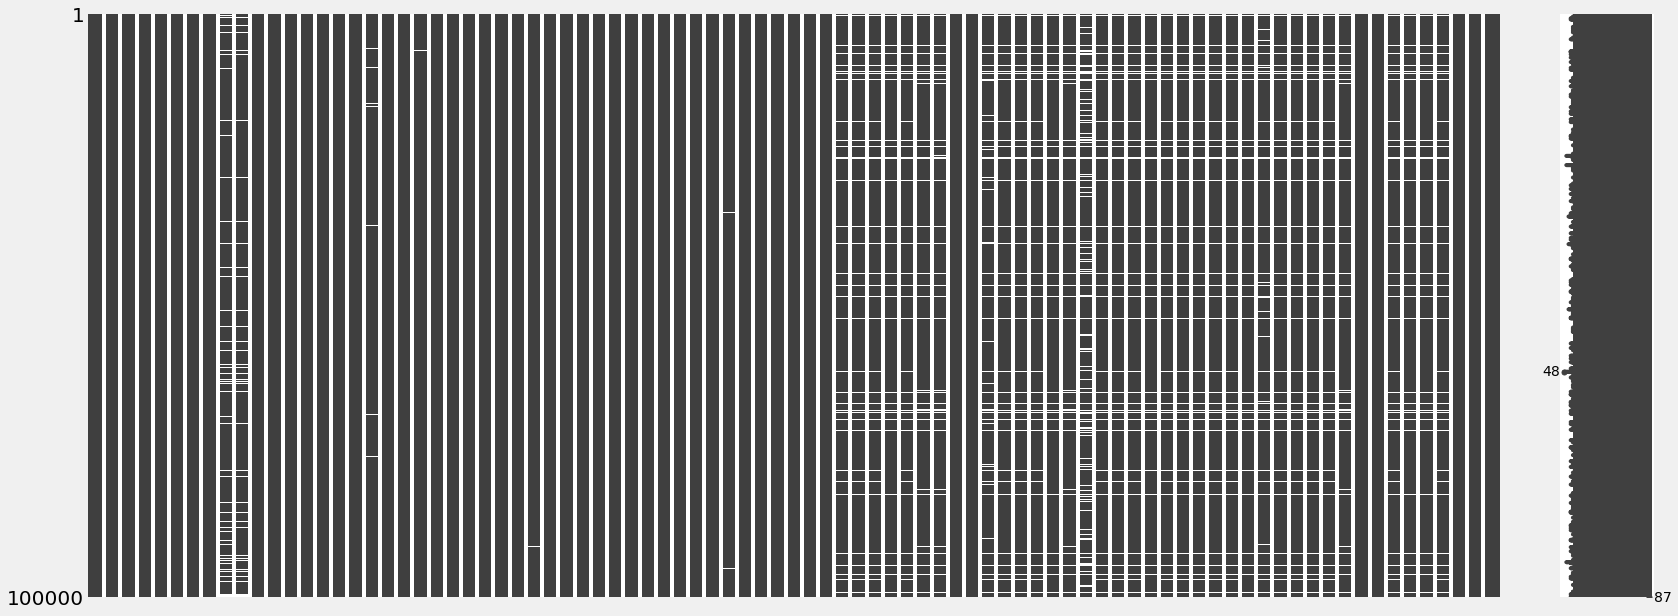

In [14]:
# visualizing the missingness partern
msno.matrix(df[0:100000])

In [15]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [0]:
int_df = df.select_dtypes(include=['float64','int64'])

In [17]:
int_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,22000,22000,22000.0,9.17,701.34,73000.0,0,13.16,0.0,2.0,7.0,0.0,33797,59.4,22.0,0.0,0.0,25251.046476,25251.05,22000.0,3251.05,0.0,0.0,0.0,701.17,0.0,1,0.0,0.0,33797.0,56900.0,3.0,4828.0,20438.0,57.1,0.0,0.0,131.0,188.0,5.0,5.0,3.0,5.0,5.0,1.0,4.0,7.0,4.0,11.0,3.0,7.0,16.0,7.0,7.0,0.0,0.0,0.0,2.0,90.9,50.0,0.0,0.0,56900.0,33797.0,47600.0,0.0
1,8000,8000,8000.0,5.32,240.92,89000.0,0,6.63,0.0,0.0,8.0,1.0,5405,34.6,16.0,0.0,0.0,8602.708787,8602.71,8000.0,602.71,0.0,0.0,0.0,3059.00,0.0,1,0.0,0.0,217913.0,15600.0,3.0,27239.0,5187.0,50.6,0.0,0.0,73.0,108.0,20.0,10.0,3.0,20.0,12.0,0.0,3.0,4.0,3.0,5.0,3.0,6.0,10.0,4.0,8.0,0.0,0.0,0.0,1.0,100.0,0.0,1.0,0.0,236146.0,17380.0,10500.0,18039.0
2,6000,6000,6000.0,9.75,192.90,65000.0,0,24.26,0.0,0.0,17.0,0.0,27715,48.5,27.0,0.0,0.0,6518.164684,6518.16,6000.0,518.16,0.0,0.0,0.0,407.59,0.0,1,0.0,0.0,41070.0,57200.0,5.0,2738.0,4791.0,70.1,0.0,0.0,49.0,137.0,4.0,4.0,0.0,22.0,7.0,0.0,2.0,7.0,3.0,7.0,2.0,15.0,24.0,7.0,17.0,0.0,0.0,0.0,2.0,100.0,33.3,0.0,0.0,89841.0,41070.0,16000.0,32641.0
3,5300,5300,5300.0,12.39,177.03,53486.0,0,32.87,0.0,0.0,18.0,0.0,31609,70.2,35.0,0.0,0.0,6369.200907,6369.20,5300.0,1069.20,0.0,0.0,0.0,176.80,0.0,1,0.0,0.0,174780.0,45000.0,4.0,9710.0,5092.0,70.6,0.0,0.0,194.0,281.0,7.0,7.0,5.0,7.0,14.0,0.0,5.0,9.0,6.0,14.0,6.0,14.0,24.0,9.0,18.0,0.0,0.0,0.0,2.0,100.0,50.0,0.0,0.0,233175.0,42735.0,17300.0,22828.0
4,8000,8000,8000.0,12.49,267.60,72550.0,0,10.72,0.0,0.0,7.0,0.0,5880,94.8,25.0,0.0,0.0,9633.193533,9633.19,8000.0,1633.19,0.0,0.0,0.0,267.19,0.0,1,0.0,0.0,173075.0,6200.0,3.0,24725.0,320.0,94.8,0.0,0.0,137.0,421.0,9.0,9.0,4.0,9.0,22.0,10.0,4.0,4.0,4.0,12.0,4.0,4.0,15.0,4.0,7.0,0.0,0.0,0.0,1.0,60.0,100.0,0.0,0.0,211884.0,8147.0,6200.0,17684.0


In [18]:
np.absolute(int_df.corr()[['loan_status']]).sort_values(by='loan_status')[35:]

,loan_status
total_rec_int,0.056074
mths_since_recent_inq,0.057126
total_rev_hi_lim,0.058353
revol_util,0.060663
inq_last_6mths,0.064318
funded_amnt_inv,0.065160
loan_amnt,0.065280
funded_amnt,0.065349
bc_util,0.067065
percent_bc_gt_75,0.068538


In [19]:
np.absolute(int_df.corr()[['loan_status']]).sort_values(by='loan_status')[35:].index

Index(['total_rec_int', 'mths_since_recent_inq', 'total_rev_hi_lim',
       'revol_util', 'inq_last_6mths', 'funded_amnt_inv', 'loan_amnt',
       'funded_amnt', 'bc_util', 'percent_bc_gt_75', 'num_rev_tl_bal_gt_0',
       'num_actv_rev_tl', 'tot_cur_bal', 'total_bc_limit', 'mort_acc',
       'tot_hi_cred_lim', 'avg_cur_bal', 'bc_open_to_buy',
       'num_tl_op_past_12m', 'dti', 'acc_open_past_24mths',
       'total_rec_late_fee', 'int_rate', 'total_pymnt_inv', 'total_pymnt',
       'last_pymnt_amnt', 'total_rec_prncp', 'collection_recovery_fee',
       'recoveries', 'loan_status', 'policy_code'],
      dtype='object')

In [0]:
cat_df = df.select_dtypes(include=['O'])

In [21]:
cat_df.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,B,B2,Registered Nurse,5 years,RENT,Source Verified,Jun-2015,n,debt_consolidation,Debt consolidation,913xx,CA,Sep-1999,f,Jun-2018,Feb-2019,Individual,N,Cash,N
1,36 months,A,A1,Foreman,10+ years,MORTGAGE,Not Verified,Aug-2016,n,debt_consolidation,Debt consolidation,740xx,OK,Dec-2001,f,Aug-2018,Feb-2019,Individual,N,Cash,N
2,36 months,B,B3,Staff Accountant,1 year,RENT,Not Verified,Mar-2016,n,debt_consolidation,Debt consolidation,980xx,WA,Oct-2004,w,May-2017,Feb-2019,Individual,N,Cash,N
3,36 months,C,C1,ADMINISTRATOR,10+ years,MORTGAGE,Source Verified,Nov-2014,n,debt_consolidation,Debt consolidation,150xx,PA,Jun-1991,w,Nov-2017,Aug-2018,Individual,N,Cash,N
4,36 months,B,B5,Chemistry Supervisor,10+ years,MORTGAGE,Not Verified,Sep-2014,n,other,Other,441xx,OH,Jul-1979,w,Sep-2017,Feb-2019,Individual,N,Cash,N


In [22]:
cat_df.shape

(391091, 21)

In [23]:
cat_df.grade.unique()

array(['B', 'A', 'C', 'D', 'E', 'G', 'F'], dtype=object)

In [24]:
cat_df.columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan',
       'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d',
       'application_type', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')

In [0]:
# Encoding grade as a predictor variable
encode = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6,'G': 7}
cat_df['grade'].replace(encode, inplace=True)

# adding encoded grade feature to int_df dataframe for modeling
int_df['grade'] = cat_df['grade'].copy()

## Modeling with continuous predictor variables

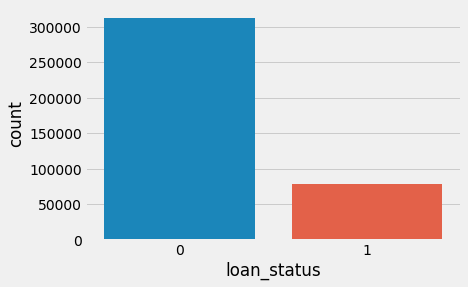

In [26]:
# plotting the distribution of the target variable
sns.countplot(df['loan_status'])

In [0]:
# filling missing values with IterativeImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=1, verbose=0)
imputed_df = imp.fit_transform(int_df)
int_df = pd.DataFrame(imputed_df, columns=int_df.columns)

In [0]:
int_df['loan_status'] = df['loan_status'].copy()

In [29]:
# finding the sum of null values in the df after Iterative imputation
int_df.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
int_rate                      0
installment                   0
                             ..
tot_hi_cred_lim               0
total_bal_ex_mort             0
total_bc_limit                0
total_il_high_credit_limit    0
grade                         0
Length: 67, dtype: int64

In [0]:
from google.colab import files

int_df.to_csv('int_df.csv')
files.download('int_df.csv')

## Model Feature Selection 

In [0]:
X_test_df = int_df[['total_rec_late_fee', 'int_rate', 'total_pymnt_inv', 'total_pymnt', 'grade', 'last_pymnt_amnt', 'total_rec_prncp',
             'collection_recovery_fee', 'recoveries', 'loan_status']].copy()

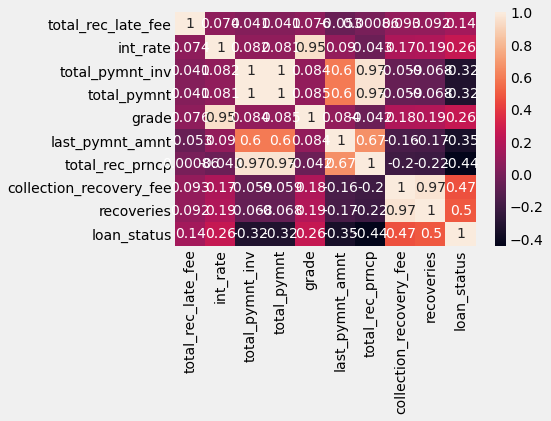

In [59]:
# checking for little or no multicollinearity between good predictor variables
sns.heatmap(X_test_df.corr(), annot=True)

In [0]:
# feature selection while dealing with multicollinearity
X = int_df[['total_rec_int', 'mths_since_recent_inq', 'total_rev_hi_lim','revol_util', 'inq_last_6mths','funded_amnt_inv','loan_amnt','funded_amnt',
            'bc_util', 'percent_bc_gt_75', 'num_rev_tl_bal_gt_0','num_actv_rev_tl', 'tot_cur_bal', 'total_bc_limit', 'mort_acc',
            'tot_hi_cred_lim', 'avg_cur_bal', 'bc_open_to_buy','num_tl_op_past_12m', 'dti', 'acc_open_past_24mths', 'total_rec_late_fee',
            'int_rate','total_rec_prncp','recoveries']]   
# Dropped columns as a result of multicollinearity: 'collection_recovery_fee','total_pymnt_inv','total_pymnt','grade','last_pymnt_amnt'
y = int_df['loan_status']

In [78]:
# values to be scaled later
X.describe()                                               

,total_rec_int,mths_since_recent_inq,total_rev_hi_lim,revol_util,inq_last_6mths,funded_amnt_inv,loan_amnt,funded_amnt,bc_util,percent_bc_gt_75,num_rev_tl_bal_gt_0,num_actv_rev_tl,tot_cur_bal,total_bc_limit,mort_acc,tot_hi_cred_lim,avg_cur_bal,bc_open_to_buy,num_tl_op_past_12m,dti,acc_open_past_24mths,total_rec_late_fee,int_rate,total_rec_prncp,recoveries
count,391091.000000,391091.000000,3.910910e+05,391091.000000,391091.000000,391091.000000,391091.000000,391091.000000,391091.000000,391091.000000,391091.000000,391091.000000,3.910910e+05,3.910910e+05,391091.000000,3.910910e+05,391091.000000,391091.000000,391091.000000,391091.000000,391091.000000,3.910910e+05,391091.000000,391091.000000,391091.000000
mean,2389.595285,7.045470,3.245535e+04,51.943314,0.658062,14383.725432,14415.314466,14406.373005,60.088853,45.387652,5.582784,5.632496,1.406196e+05,2.150080e+04,1.658403,1.738544e+05,13528.051570,10014.613452,2.167590,18.226554,4.668024,1.556729e+00,13.263880,12161.530052,234.968618
std,2592.454542,5.638721,3.238990e+04,24.532675,0.940042,8710.172632,8712.171819,8707.771660,27.853250,35.183592,3.122325,3.203746,1.526565e+05,2.104393e+04,2.207548,1.740294e+05,15808.446200,14949.261506,1.805366,10.866199,3.133304,1.067662e+01,4.755226,8861.606328,939.759603
min,0.000000,-57.239791,-5.251100e+04,-14.543574,0.000000,0.000000,500.000000,500.000000,0.000000,-58.545598,0.000000,0.000000,-5.521628e+04,0.000000e+00,-26.998407,-7.337556e+04,-11202.487439,-36934.348487,-1.582328,0.000000,-0.907539,-2.000000e-10,5.310000,0.000000,0.000000
25%,763.320000,2.000000,1.430000e+04,33.600000,0.000000,7900.000000,8000.000000,8000.000000,39.007786,14.300000,3.000000,3.000000,3.102000e+04,8.000000e+03,0.000000,5.173500e+04,3251.000000,1453.000000,1.000000,11.760000,2.000000,0.000000e+00,9.750000,5000.000000,0.000000
50%,1564.330000,6.000000,2.440000e+04,52.400000,0.000000,12000.000000,12000.000000,12000.000000,63.200000,45.657118,5.000000,5.000000,9.180500e+04,1.550000e+04,1.000000,1.249000e+05,8265.000000,4841.000000,2.000000,17.570000,4.000000,0.000000e+00,12.790000,10000.000000,0.000000
75%,3019.675000,10.126842,3.990000e+04,70.800000,1.000000,20000.000000,20000.000000,20000.000000,84.300000,75.000000,7.000000,7.000000,2.034335e+05,2.750000e+04,3.000000,2.436440e+05,18089.000000,12223.000000,3.000000,24.010000,6.000000,0.000000e+00,15.990000,17125.000000,0.000000
max,27884.800000,76.352927,1.649101e+06,892.300000,8.000000,40000.000000,40000.000000,40000.000000,533.476983,106.220248,43.000000,47.000000,4.151547e+06,1.105500e+06,51.000000,9.999999e+06,497484.000000,497445.000000,32.000000,999.000000,48.000000,9.298000e+02,30.990000,40000.000000,39859.550000


In [0]:
# splitting data into train and tests sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

### Logistic Regression 

In [0]:
logreg_model_1 = LogisticRegression()
logreg_model_1.fit(X_train,y_train)
#y_pred_train = logreg_model_1.predict(X_train)
y_pred_test = logreg_model_1.predict(X_test)

In [79]:
metrics.accuracy_score(y_test, y_pred_test)

0.9990488171581111

In [80]:
metrics.confusion_matrix(y_test, y_pred_test)

array([[78132,     9],
       [   84, 19548]])

In [81]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     78141
           1       1.00      1.00      1.00     19632

    accuracy                           1.00     97773
   macro avg       1.00      1.00      1.00     97773
weighted avg       1.00      1.00      1.00     97773



In [0]:
y_pred_prob = logreg_model_1.predict_proba(X_test)[:,1]

In [83]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9991011581659373

### Support Vector Machine Classifier

In [0]:
#svm_model_1 = SVC(kernel='linear')
#svm_model_1.fit(X_train,y_train)
#y_pred_train = svm_model_1.predict(X_train)
#y_pred_test = svm_model_1.predict(X_test)

In [0]:
#metrics.accuracy_score(y_test, y_pred_test)

In [0]:
#metrics.confusion_matrix(y_test, y_pred_test)

In [0]:
#print(metrics.classification_report(y_test, y_pred_test))

### RandomForestClassifier

In [0]:
rf_model_1 = RandomForestClassifier()
rf_model_1.fit(X_train,y_train)
#y_pred_train = rf_model_1.predict(X_train)
y_pred_test = rf_model_1.predict(X_test)

In [85]:
metrics.accuracy_score(y_test, y_pred_test)

0.9965941517596882

In [86]:
metrics.confusion_matrix(y_test, y_pred_test)

array([[78140,     1],
       [  332, 19300]])

In [87]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     78141
           1       1.00      0.98      0.99     19632

    accuracy                           1.00     97773
   macro avg       1.00      0.99      0.99     97773
weighted avg       1.00      1.00      1.00     97773



In [88]:
y_pred_prob = rf_model_1.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.9998795734816067

## MinMaxScaler
* Scaling features and remodeling

In [0]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [0]:
mm = MinMaxScaler()
feature_names = X_train.columns
X_train_mm = mm.fit_transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, columns=feature_names)
X_test_mm = mm.transform(X_test)
X_test_mm = pd.DataFrame(X_test_mm, columns=feature_names)

In [102]:
# showing a DESC of the normalized X_train features
X_train_mm.describe()

,total_rec_int,mths_since_recent_inq,total_rev_hi_lim,revol_util,inq_last_6mths,funded_amnt_inv,loan_amnt,funded_amnt,bc_util,percent_bc_gt_75,num_rev_tl_bal_gt_0,num_actv_rev_tl,tot_cur_bal,total_bc_limit,mort_acc,tot_hi_cred_lim,avg_cur_bal,bc_open_to_buy,num_tl_op_past_12m,dti,acc_open_past_24mths,total_rec_late_fee,int_rate,total_rec_prncp,recoveries
count,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000,293318.000000
mean,0.085588,0.481238,0.049892,0.058219,0.082295,0.359388,0.352066,0.351845,0.112666,0.630963,0.129765,0.119771,0.046608,0.019422,0.367443,0.024566,0.048191,0.087814,0.111701,0.018243,0.114052,0.001674,0.309663,0.303943,0.005890
std,0.092972,0.042216,0.018859,0.027514,0.117670,0.217633,0.220435,0.220334,0.052228,0.213573,0.072551,0.068089,0.036369,0.019040,0.028305,0.017356,0.031192,0.027952,0.053817,0.010964,0.064074,0.011438,0.185105,0.221461,0.023568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027330,0.443436,0.039263,0.037655,0.000000,0.197002,0.189873,0.189873,0.073293,0.442116,0.069767,0.063830,0.020510,0.007237,0.346140,0.012423,0.027913,0.071830,0.076895,0.011772,0.059450,0.000000,0.172897,0.125000,0.000000
50%,0.056026,0.473378,0.045161,0.058725,0.000000,0.300000,0.291139,0.291139,0.118468,0.633130,0.116279,0.106383,0.034983,0.014021,0.358961,0.019698,0.037822,0.078155,0.106673,0.017578,0.100343,0.000000,0.289330,0.250000,0.000000
75%,0.108227,0.504275,0.054308,0.079346,0.125000,0.500000,0.493671,0.493671,0.158020,0.810517,0.162791,0.148936,0.061537,0.024876,0.384603,0.031506,0.057192,0.091930,0.136451,0.024044,0.141237,0.000000,0.415888,0.427500,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Logistic Regression 

In [0]:
logreg_model_2 = LogisticRegression()
logreg_model_2.fit(X_train_mm,y_train)
#y_pred_train = logreg_model_2.predict(X_train_mm)
y_pred_test = logreg_model_2.predict(X_test_mm)

In [106]:
metrics.accuracy_score(y_test, y_pred_test)

0.9905597659885653

In [107]:
metrics.confusion_matrix(y_test, y_pred_test)

array([[78129,    12],
       [  911, 18721]])

In [108]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     78141
           1       1.00      0.95      0.98     19632

    accuracy                           0.99     97773
   macro avg       0.99      0.98      0.99     97773
weighted avg       0.99      0.99      0.99     97773



In [0]:
y_pred_prob = logreg_model_2.predict_proba(X_test_mm)[:,1]

In [110]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9985441788367709

### Support Vector Machine Classifier

In [0]:
#svm_model_2 = SVC(kernel='linear')
#svm_model_2.fit(X_train_mm,y_train)
#y_pred_train = svm_model_2.predict(X_train_mm)
#y_pred_test = svm_model_2.predict(X_test_mm)

In [0]:
#metrics.accuracy_score(y_test, y_pred_test)

In [0]:
#metrics.confusion_matrix(y_test, y_pred_test)

In [0]:
#print(metrics.classification_report(y_test, y_pred_test))

### RandomForestClassifier

In [0]:
rf_model_2 = RandomForestClassifier()
rf_model_2.fit(X_train_mm,y_train)
#y_pred_train = rf_model_2.predict(X_train_mm)
y_pred_test = rf_model_2.predict(X_test_mm)

In [112]:
metrics.accuracy_score(y_test, y_pred_test)

0.9965532406697145

In [113]:
metrics.confusion_matrix(y_test, y_pred_test)

array([[78139,     2],
       [  335, 19297]])

In [114]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     78141
           1       1.00      0.98      0.99     19632

    accuracy                           1.00     97773
   macro avg       1.00      0.99      0.99     97773
weighted avg       1.00      1.00      1.00     97773



In [129]:
y_pred_prob = rf_model_2.predict_proba(X_test_mm)[:,1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.9998098524711465

### StandardScaler

In [0]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=feature_names)
X_test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=feature_names)

In [117]:
X_train_sc.describe()

,total_rec_int,mths_since_recent_inq,total_rev_hi_lim,revol_util,inq_last_6mths,funded_amnt_inv,loan_amnt,funded_amnt,bc_util,percent_bc_gt_75,num_rev_tl_bal_gt_0,num_actv_rev_tl,tot_cur_bal,total_bc_limit,mort_acc,tot_hi_cred_lim,avg_cur_bal,bc_open_to_buy,num_tl_op_past_12m,dti,acc_open_past_24mths,total_rec_late_fee,int_rate,total_rec_prncp,recoveries
count,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05,2.933180e+05
mean,-3.701210e-17,-2.577164e-16,-4.452126e-17,5.141202e-16,3.053184e-15,-6.609218e-16,-4.410744e-16,-2.869472e-16,5.409653e-16,-3.141465e-17,5.160286e-16,-1.347165e-15,1.647621e-16,-1.174955e-17,3.293239e-16,8.901754e-17,-1.104763e-16,2.355058e-18,-3.016639e-15,5.376185e-16,-7.413602e-16,8.136936e-15,7.061707e-16,1.407266e-15,-3.813436e-15
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-9.205741e-01,-1.139936e+01,-2.645582e+00,-2.115997e+00,-6.993685e-01,-1.651352e+00,-1.597143e+00,-1.596876e+00,-2.157188e+00,-2.954326e+00,-1.788598e+00,-1.759042e+00,-1.281529e+00,-1.020105e+00,-1.298143e+01,-1.415457e+00,-1.544969e+00,-3.141638e+00,-2.075570e+00,-1.663847e+00,-1.780003e+00,-1.463648e-01,-1.672911e+00,-1.372447e+00,-2.499192e-01
25%,-6.266142e-01,-8.954464e-01,-5.636104e-01,-7.473969e-01,-6.993685e-01,-7.461467e-01,-7.357845e-01,-7.351210e-01,-7.538727e-01,-8.842289e-01,-8.269657e-01,-8.215891e-01,-7.175842e-01,-6.400250e-01,-7.526073e-01,-6.996924e-01,-6.500863e-01,-5.718446e-01,-6.467363e-01,-5.901940e-01,-8.521781e-01,-1.463648e-01,-7.388587e-01,-8.080128e-01,-2.499192e-01
50%,-3.179639e-01,-1.861991e-01,-2.509034e-01,1.836739e-02,-6.993685e-01,-2.728832e-01,-2.763934e-01,-2.755184e-01,1.110864e-01,1.014748e-02,-1.858777e-01,-1.966202e-01,-3.196418e-01,-2.837005e-01,-2.996613e-01,-2.804895e-01,-3.324074e-01,-3.455571e-01,-9.342394e-02,-6.067139e-02,-2.139577e-01,-1.463648e-01,-1.098456e-01,-2.435781e-01,-2.499192e-01
75%,2.435037e-01,5.456857e-01,2.341394e-01,7.678388e-01,3.629250e-01,6.460963e-01,6.423890e-01,6.436869e-01,8.683741e-01,8.407193e-01,4.552104e-01,4.283487e-01,4.104849e-01,2.864188e-01,6.062305e-01,3.998747e-01,2.885735e-01,1.472544e-01,4.598884e-01,5.291072e-01,4.242627e-01,-1.463648e-01,5.738642e-01,5.579190e-01,-2.499192e-01
max,9.835355e+00,1.228821e+01,5.038022e+01,3.422930e+01,7.798979e+00,2.943545e+00,2.939345e+00,2.941700e+00,1.698952e+01,1.727924e+00,1.199480e+01,1.292773e+01,2.621430e+01,5.150214e+01,2.234763e+01,5.620245e+01,3.051461e+01,3.263452e+01,1.650595e+01,8.954185e+01,1.382689e+01,8.727897e+01,3.729448e+00,3.143030e+00,4.218017e+01


### Logistic Regression 

In [0]:
logreg_model_3 = LogisticRegression()
logreg_model_3.fit(X_train_sc,y_train)
#y_pred_train = logreg_model_3.predict(X_train_sc)
y_pred_test = logreg_model_3.predict(X_test_sc)

In [119]:
metrics.accuracy_score(y_test, y_pred_test)

0.9969828071144385

In [120]:
metrics.confusion_matrix(y_test, y_pred_test)

array([[78135,     6],
       [  289, 19343]])

In [121]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     78141
           1       1.00      0.99      0.99     19632

    accuracy                           1.00     97773
   macro avg       1.00      0.99      1.00     97773
weighted avg       1.00      1.00      1.00     97773



In [0]:
y_pred_prob = logreg_model_3.predict_proba(X_test_sc)[:,1]

In [123]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9995688739506866

### Support Vector Machine Classifier

In [0]:
#svm_model_3 = SVC(kernel='linear')
#svm_model_3.fit(X_train_mm,y_train)
#y_pred_train = svm_model_3.predict(X_train_sc)
#y_pred_test = svm_model_3.predict(X_test_sc)

In [0]:
#metrics.accuracy_score(y_test, y_pred_test)

In [0]:
#metrics.confusion_matrix(y_test, y_pred_test)

In [0]:
#print(metrics.classification_report(y_test, y_pred_test))

### RandomForestClassifier

In [0]:
rf_model_3 = RandomForestClassifier()
rf_model_3.fit(X_train_sc,y_train)
#y_pred_train = rf_model_3.predict(X_train_sc)
y_pred_test = rf_model_3.predict(X_test_sc)

In [125]:
metrics.accuracy_score(y_test, y_pred_test)

0.9966862017121291

In [126]:
metrics.confusion_matrix(y_test, y_pred_test)

array([[78140,     1],
       [  323, 19309]])

In [127]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     78141
           1       1.00      0.98      0.99     19632

    accuracy                           1.00     97773
   macro avg       1.00      0.99      0.99     97773
weighted avg       1.00      1.00      1.00     97773



In [128]:
y_pred_prob = rf_model_3.predict_proba(X_test_sc)[:,1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.9998665085126508